In [1]:
import pandas as pd
import numpy as np
import random
import nltk
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Seed for reproducibility
seed_value = 123
np.random.seed(seed_value)
random.seed(seed_value)

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


# Convert labels to numeric values
df['Label'] = df['Tag'].map({'spam': 1, 'ham': 0})
df_test['Label'] = df_test['Tag'].map({'spam': 1, 'ham': 0})


print(df.shape)
df.head()

class_counts = df['Label'].value_counts()
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['Class', 'Count']
class_counts_df['Percentage'] = ((class_counts_df['Count'] / class_counts_df['Count'].sum()) * 100).round(2)
class_counts_df

(5016, 3)


,Class,Count,Percentage
0,0,4344,86.6
1,1,672,13.4


In [2]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Get stopwords and define what stopwords to keep
stop_words = set(stopwords.words('english'))
important_stopwords = {"now", "today", "still", "soon", "only", "immediately", "urgent", "limited"}
custom_stop_words = stop_words - important_stopwords
processed_text = []

for text in df['Text']:
    # Lowercase
    text_lower = text.lower()
    
    # Replace number with the token NUM
    text_with_num = re.sub(r'\b\d+\b', 'NUM', text_lower)
    
    # Keep important symbols as currency symbols
    text_with_symbols = re.sub(r'[^a-zA-Z0-9£$€]', ' ', text_with_num)
    
    # Remove stopwords 
    words = text_with_symbols.split()
    words_without_stopwords = [word for word in words if word not in custom_stop_words]
    
    # Lemamtization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words_without_stopwords]    

    # Add processed text
    p_text = ' '.join(lemmatized_words)
    processed_text.append(p_text)
    
df['Message_processed'] = processed_text
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34659\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\34659\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Tag,Text,Label,Message_processed
0,ham,I calls you later. Afternoon onwords mtnl serv...,0,call later afternoon onwords mtnl service get ...
1,ham,Do u ever get a song stuck in your head for no...,0,u ever get song stuck head reason go away til ...
2,spam,u r a winner U ave been specially selected 2 r...,1,u r winner u ave specially selected NUM receiv...
3,ham,"Actually, my mobile is full of msg. And i m do...",0,actually mobile full msg work online need send...
4,ham,But we havent got da topic yet rite?,0,havent got da topic yet rite


In [3]:
processed_text=[]
for text in df_test['Text']:
    # Lowercase
    text_lower = text.lower()
    
    # Replace number with the token NUM
    text_with_num = re.sub(r'\b\d+\b', 'NUM', text_lower)
    
    # Keep important symbols as currency symbols
    text_with_symbols = re.sub(r'[^a-zA-Z0-9£$€]', ' ', text_with_num)
    
    # Remove stopwords 
    words = text_with_symbols.split()
    words_without_stopwords = [word for word in words if word not in custom_stop_words]
    
    # Lemamtization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words_without_stopwords]    

    # Add processed text
    p_text = ' '.join(lemmatized_words)
    processed_text.append(p_text)
    
df_test['Message_processed'] = processed_text
df_test.head()


,Tag,Text,Label,Message_processed
0,spam,"Xmas Offer! Latest Motorola, SonyEricsson & No...",1,xmas offer latest motorola sonyericsson nokia ...
1,ham,Ü dun need to pick ur gf?,0,dun need pick ur gf
2,ham,"Bloody hell, cant believe you forgot my surnam...",0,bloody hell cant believe forgot surname mr ill...
3,ham,Nothin comes to my mind. Ü help me buy hanger ...,0,nothin come mind help buy hanger lor ur laptop...
4,ham,"K, text me when you're on the way",0,k text way


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np


X_train = df["Message_processed"]
y_train = df["Label"] 

X_test = df_test["Message_processed"]
y_test = df_test["Label"] 

# Vectorize text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Accuracy: 0.9838709677419355
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       483
           1       1.00      0.88      0.94        75

    accuracy                           0.98       558
   macro avg       0.99      0.94      0.96       558
weighted avg       0.98      0.98      0.98       558



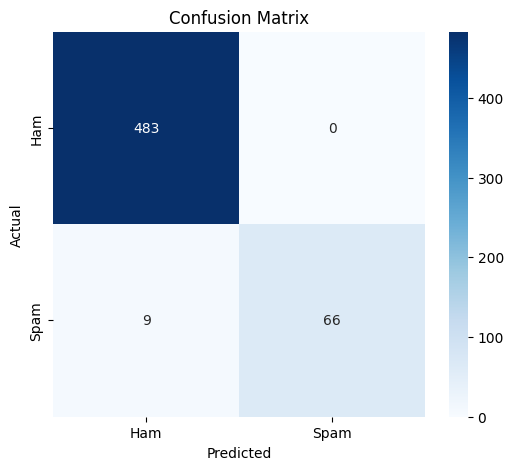


Top words indicating spam:
num: 6.5110
txt: 3.5745
uk: 3.5634
mobile: 3.2699
service: 3.0447
free: 2.9218
text: 2.9161
www: 2.8737
150p: 2.7281
reply: 2.7225

Top words indicating ham:
work: -0.9352
sorry: -1.0960
got: -1.1065
home: -1.1357
lor: -1.1628
da: -1.1758
later: -1.1985
ok: -1.4514
gt: -1.7869
lt: -1.7915


In [7]:
# Train a Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred = classifier.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Extract feature importance
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]
important_words = sorted(zip(coefficients, feature_names), key=lambda x: x[0], reverse=True)

# Display top important words for spam classification
print("\nTop words indicating spam:")
for coef, word in important_words[:10]:
    print(f"{word}: {coef:.4f}")

print("\nTop words indicating ham:")
for coef, word in important_words[-10:]:
    print(f"{word}: {coef:.4f}")